# MountainCar-v0

## Components

### Libraries

In [1]:
!pip install keras-rl2
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Requirement already up-to-date: colabgymrender in /usr/local/lib/python3.7/dist-packages (1.0.9)


In [2]:
from gym.envs.classic_control.mountain_car import MountainCarEnv
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, MaxBoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger
from rl.agents import DQNAgent
from colabgymrender.recorder import Recorder
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import json
import gym

print(f'tensorflow version = {tf.__version__}')
print(tf.config.list_physical_devices('GPU'))
print()

# FIXME
display = Display(visible=0, size=(400, 300))
display.start()

tensorflow version = 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



### Environment

In [3]:
class MountainCarWithNoiseEnv(MountainCarEnv):
    def __init__(self, goal_velocity=0, sigma=0):
        super().__init__(goal_velocity)
        self.sigma = sigma

    def step(self, action):
        state, reward, done, info = super().step(action)
        
        if self.sigma > 0:
            state[0] += np.random.normal(0, self.sigma)
            state[1] += np.random.normal(0, self.sigma)
        
        return state, reward, done, info

### Neural Network

In [4]:
def get_model(env):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(env.action_space.n))
    
    return model

### Agent

In [5]:
def run_experiment(experiment, policy, sigma):   
    results_file_name = get_results_file_name(experiment)
    
    env = MountainCarWithNoiseEnv(sigma=sigma)
    
    env.seed(0)
    np.random.seed(0)
    
    model = get_model(env)
    
    agent = DQNAgent(model=model,
                        nb_actions=env.action_space.n, 
                        memory=SequentialMemory(limit=50000, window_length=1), 
                        nb_steps_warmup=50, 
                        target_model_update=1e-2, 
                        policy=policy)
    
    callbacks=[FileLogger(results_file_name)]
    
    agent.compile(keras.optimizers.Adam(lr=1e-3), metrics=['mae'])
    agent.fit(env, nb_steps=100000, nb_max_episode_steps=200, callbacks=callbacks,
                visualize=False, verbose=1) # FIXME
            
    # input("Press enter to start to testing...")
    # agent.test(env, nb_episodes=5, visualize=True)

    env.close()

### Plots

In [6]:
from google.colab import drive
drive.mount('/content/drive')

MAIN_DIR = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def get_results_file_name(experiment):
    return MAIN_DIR + experiment + '.json'

def exponential_smoothing(x, alpha):
    y = np.zeros_like(x)
    
    y[0] = x[0]
    
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    
    return y

def plot_results(experiments):
    if type(experiments) == str:
        experiments = [experiments]

    plt.figure(figsize=(8, 6))
    plt.title('Mean reward per episode (smooth)')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    for experiment in experiments:
        results_file_name = get_results_file_name(experiment)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        rewards = results['episode_reward']
        rewards = exponential_smoothing(rewards, 0.01)
        plt.plot(episodes, rewards, label=experiment)
    if len(experiments) > 1:
        plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.title('Mean Q per episode')
    plt.xlabel('Episodes')
    plt.ylabel('Q')
    for experiment in experiments:
        results_file_name = get_results_file_name(experiment)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        q = results['mean_q']
        plt.plot(episodes, q, label=experiment)
    if len(experiments) > 1:
        plt.legend()
    plt.show()

## Experiments

### Without noise

#### Greedy

In [8]:
run_experiment('Greedy', GreedyQPolicy(), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.410 - mae: 19.981 - mean_q: -29.553

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -1.0000
54 episodes - episode_reward: -184.204 [-200.000, -111.000] - loss: 6.206 - mae: 35.753 - mean_q: -52.871

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -1.0000
65 episodes - episode_reward: -153.923 [-200.000, -88.000] - loss: 4.482 - mae: 34.933 - mean_q: -51.516

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -1.0000
78 episodes - episode_reward: -127.974 [-200.000, -85.000] - loss: 2.915 - mae: 31.012 - mean_q: -45.647

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 87s 9ms/step -

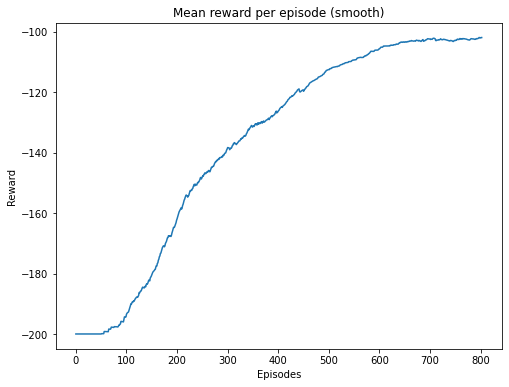

<Figure size 432x288 with 0 Axes>

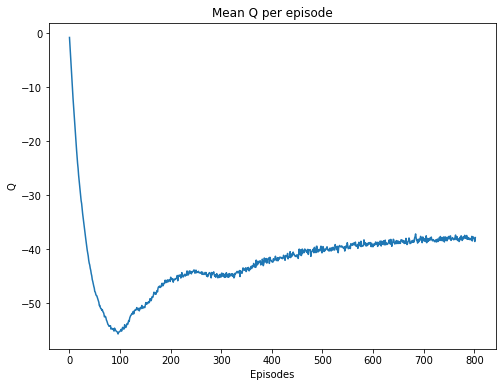

<Figure size 432x288 with 0 Axes>

In [45]:
plot_results('Greedy')

#### EpsGreedy eps=0.05

In [10]:
run_experiment('EpsGreedy eps=0.05', EpsGreedyQPolicy(eps=0.05), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.398 - mae: 20.098 - mean_q: -29.743

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 85s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.700 [-200.000, -185.000] - loss: 6.947 - mae: 37.277 - mean_q: -55.248

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 86s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -198.480 [-200.000, -168.000] - loss: 8.211 - mae: 40.149 - mean_q: -59.506

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -1.0000
65 episodes - episode_reward: -154.585 [-200.000, -85.000] - loss: 5.785 - mae: 37.440 - mean_q: -55.337

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 89s 9ms/step 

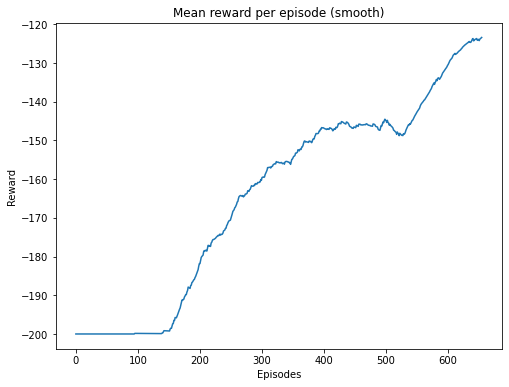

<Figure size 432x288 with 0 Axes>

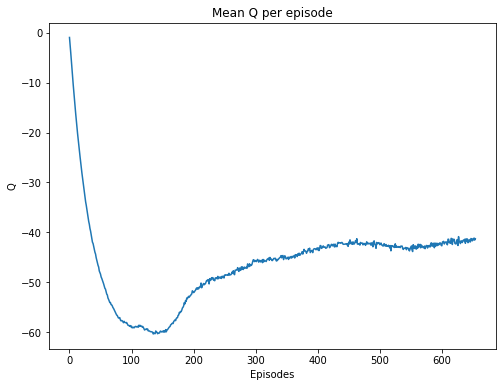

<Figure size 432x288 with 0 Axes>

In [46]:
plot_results('EpsGreedy eps=0.05')

#### EpsGreedy eps=0.1

In [12]:
run_experiment('EpsGreedy eps=0.1', EpsGreedyQPolicy(eps=0.1), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.120 [-200.000, -156.000] - loss: 2.507 - mae: 20.248 - mean_q: -29.940

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -198.600 [-200.000, -166.000] - loss: 6.656 - mae: 36.421 - mean_q: -53.937

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -1.0000
59 episodes - episode_reward: -170.288 [-200.000, -114.000] - loss: 5.513 - mae: 35.692 - mean_q: -52.683

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -1.0000
71 episodes - episode_reward: -139.972 [-200.000, -91.000] - loss: 3.102 - mae: 30.747 - mean_q: -45.283

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 90s 9ms/step 

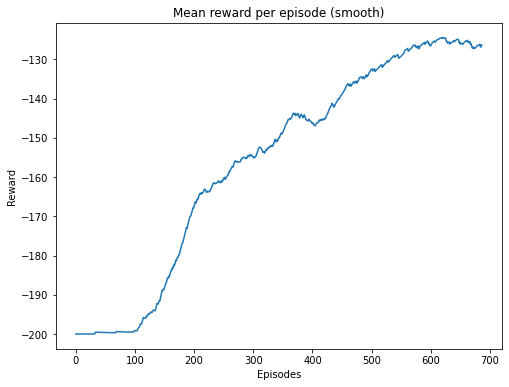

<Figure size 432x288 with 0 Axes>

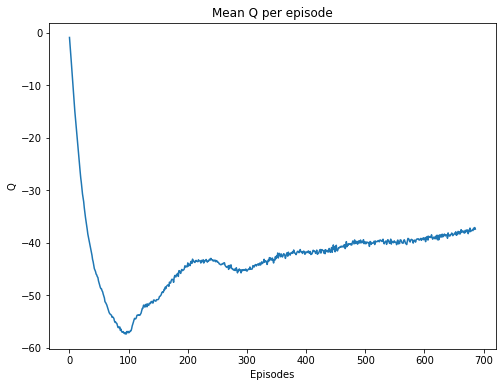

<Figure size 432x288 with 0 Axes>

In [47]:
plot_results('EpsGreedy eps=0.1')

#### EpsGreedy eps=0.2

In [14]:
run_experiment('EpsGreedy eps=0.2', EpsGreedyQPolicy(eps=0.2), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 89s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.478 - mae: 20.070 - mean_q: -29.675

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 90s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 6.756 - mae: 36.600 - mean_q: -54.203

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.540 [-200.000, -179.000] - loss: 7.157 - mae: 38.365 - mean_q: -56.750

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 92s 9ms/step - reward: -1.0000
57 episodes - episode_reward: -174.526 [-200.000, -106.000] - loss: 5.817 - mae: 36.380 - mean_q: -53.804

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 93s 9ms/step

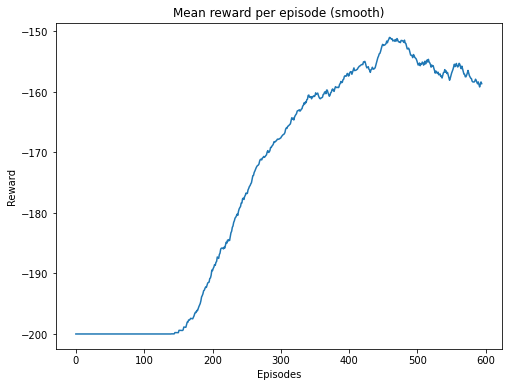

<Figure size 432x288 with 0 Axes>

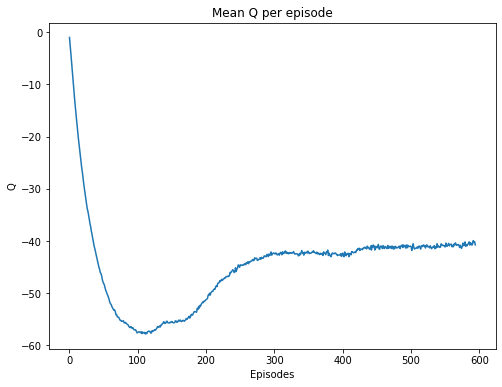

<Figure size 432x288 with 0 Axes>

In [48]:
plot_results('EpsGreedy eps=0.2')

#### MaxBoltzmann eps=0.05

In [16]:
run_experiment('MaxBoltzmann eps=0.05', MaxBoltzmannQPolicy(eps=0.05), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.514 - mae: 19.966 - mean_q: -29.493

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.700 [-200.000, -185.000] - loss: 6.644 - mae: 35.703 - mean_q: -52.846

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -1.0000
51 episodes - episode_reward: -195.647 [-200.000, -162.000] - loss: 7.649 - mae: 39.156 - mean_q: -57.980

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: -1.0000
63 episodes - episode_reward: -157.413 [-200.000, -90.000] - loss: 5.578 - mae: 35.879 - mean_q: -52.927

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 95s 9ms/step 

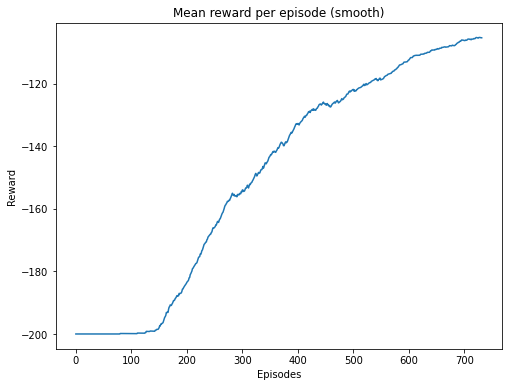

<Figure size 432x288 with 0 Axes>

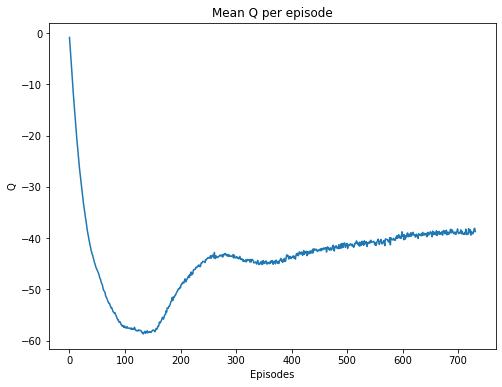

<Figure size 432x288 with 0 Axes>

In [49]:
plot_results('MaxBoltzmann eps=0.05')

#### MaxBoltzmann eps=0.1

In [18]:
run_experiment('MaxBoltzmann eps=0.1', MaxBoltzmannQPolicy(eps=0.1), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 95s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.502 - mae: 20.265 - mean_q: -29.973

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 95s 9ms/step - reward: -1.0000
50 episodes - episode_reward: -199.020 [-200.000, -166.000] - loss: 7.326 - mae: 36.373 - mean_q: -53.848

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 96s 10ms/step - reward: -1.0000
57 episodes - episode_reward: -173.965 [-200.000, -102.000] - loss: 7.027 - mae: 38.424 - mean_q: -56.795

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -1.0000
66 episodes - episode_reward: -151.742 [-200.000, -89.000] - loss: 4.288 - mae: 34.279 - mean_q: -50.585

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 99s 10ms/st

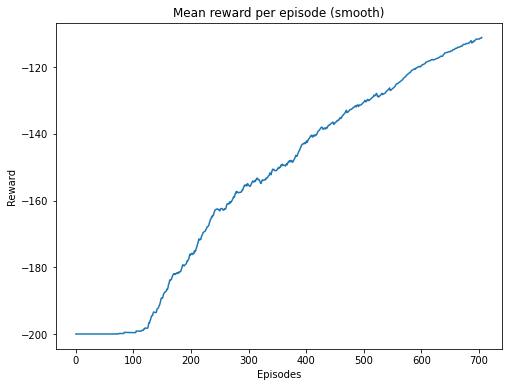

<Figure size 432x288 with 0 Axes>

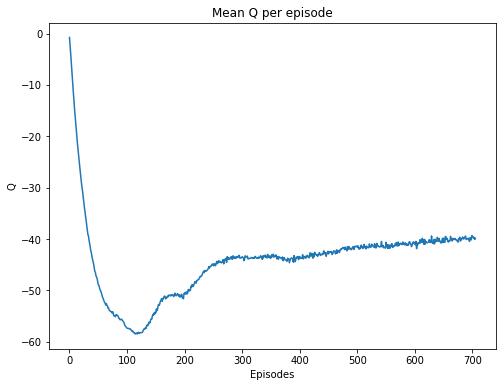

<Figure size 432x288 with 0 Axes>

In [50]:
plot_results('MaxBoltzmann eps=0.1')

#### MaxBoltzmann eps=*0.2*

In [20]:
run_experiment('MaxBoltzmann eps=0.2', MaxBoltzmannQPolicy(eps=0.2), 0)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.564 - mae: 20.138 - mean_q: -29.753

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 6.800 - mae: 35.564 - mean_q: -52.609

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 99s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.619 - mae: 38.334 - mean_q: -56.716

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 98s 10ms/step - reward: -1.0000
50 episodes - episode_reward: -197.760 [-200.000, -134.000] - loss: 8.303 - mae: 39.908 - mean_q: -59.111

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 100s 10m

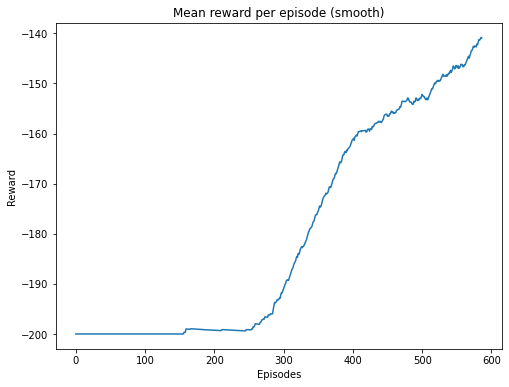

<Figure size 432x288 with 0 Axes>

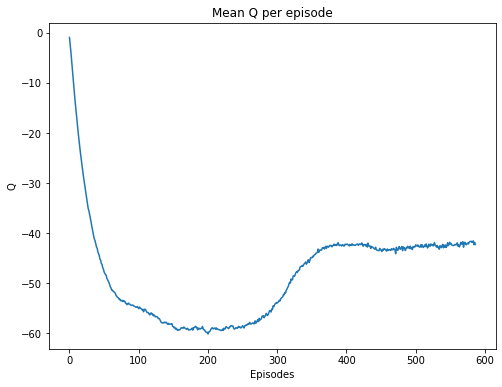

<Figure size 432x288 with 0 Axes>

In [51]:
plot_results('MaxBoltzmann eps=0.2')

#### All Results

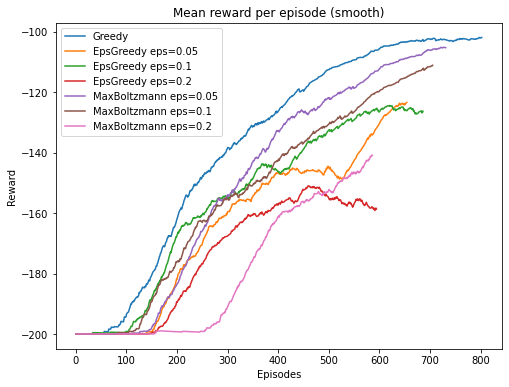

<Figure size 432x288 with 0 Axes>

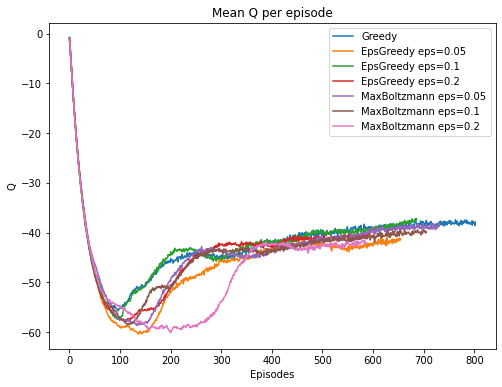

<Figure size 432x288 with 0 Axes>

In [52]:
experiments = [
               'Greedy',
               'EpsGreedy eps=0.05',
               'EpsGreedy eps=0.1',
               'EpsGreedy eps=0.2',
               'MaxBoltzmann eps=0.05',
               'MaxBoltzmann eps=0.1',
               'MaxBoltzmann eps=0.2',
               ]
plot_results(experiments, 'all_policies_without_noise_')

### With noise

#### EpsGreedy eps=0.1, sigma=1e-4

In [26]:
run_experiment('EpsGreedy eps=0.1, sigma=1e-4', EpsGreedyQPolicy(eps=0.1), 1e-4)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 120s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.547 - mae: 20.021 - mean_q: -29.619

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 119s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -199.980 [-200.000, -199.000] - loss: 6.612 - mae: 36.282 - mean_q: -53.744

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 121s 12ms/step - reward: -1.0000
51 episodes - episode_reward: -193.784 [-200.000, -119.000] - loss: 7.240 - mae: 38.253 - mean_q: -56.678

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 122s 12ms/step - reward: -1.0000
57 episodes - episode_reward: -176.965 [-200.000, -112.000] - loss: 6.200 - mae: 38.472 - mean_q: -56.946

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 124s

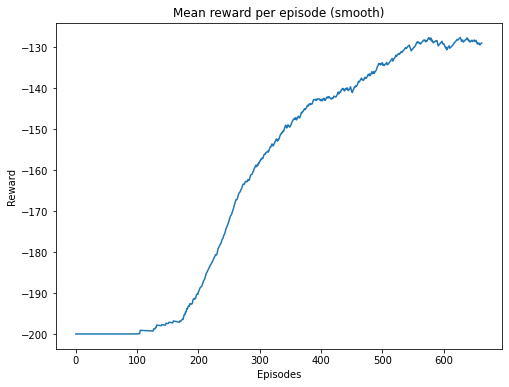

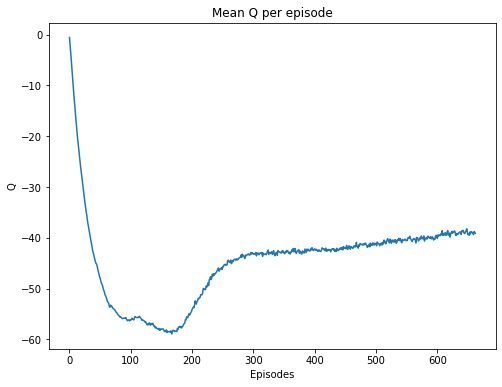

In [27]:
plot_results('EpsGreedy eps=0.1, sigma=1e-4')

#### EpsGreedy eps=0.1, sigma=1e-3

In [28]:
run_experiment('EpsGreedy eps=0.1, sigma=1e-3', EpsGreedyQPolicy(eps=0.1), 1e-3)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 122s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -199.200 [-200.000, -160.000] - loss: 2.689 - mae: 20.141 - mean_q: -29.793

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 121s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -198.300 [-200.000, -150.000] - loss: 7.081 - mae: 36.520 - mean_q: -54.089

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 123s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.432 - mae: 38.473 - mean_q: -56.827

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 124s 12ms/step - reward: -1.0000
58 episodes - episode_reward: -172.690 [-200.000, -93.000] - loss: 6.255 - mae: 35.880 - mean_q: -52.980

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 126s 

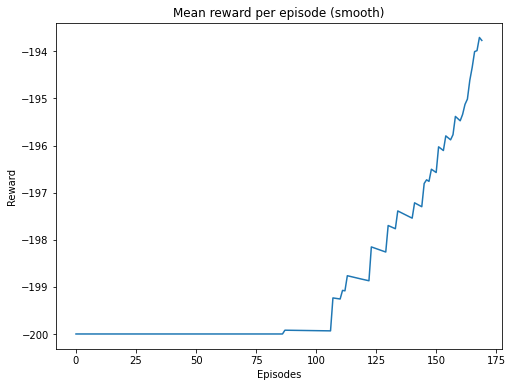

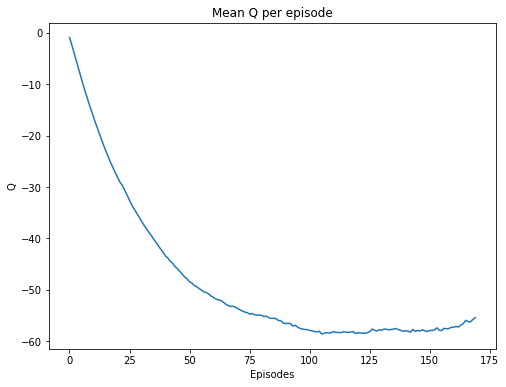

In [29]:
plot_results('EpsGreedy eps=0.1, sigma=1e-3')

#### EpsGreedy eps=0.1, sigma=1e-2

In [30]:
run_experiment('EpsGreedy eps=0.1, sigma=1e-2', EpsGreedyQPolicy(eps=0.1), 1e-2)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 125s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.471 - mae: 20.363 - mean_q: -30.108

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 125s 13ms/step - reward: -1.0000
51 episodes - episode_reward: -195.784 [-200.000, -140.000] - loss: 6.974 - mae: 36.149 - mean_q: -53.351

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 127s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 8.072 - mae: 38.394 - mean_q: -56.569

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 128s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -199.780 [-200.000, -189.000] - loss: 8.078 - mae: 39.095 - mean_q: -57.668

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 130s

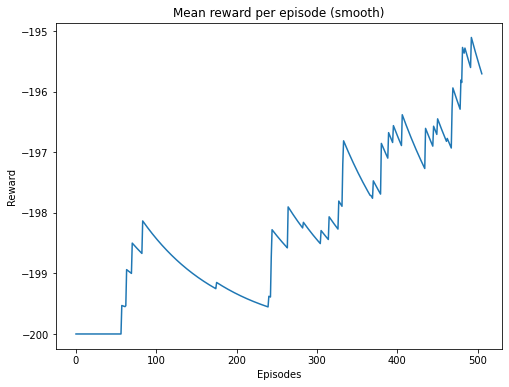

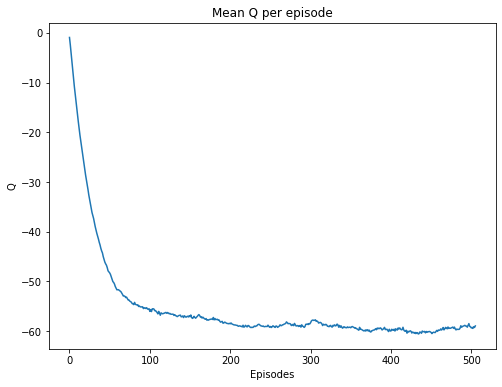

In [31]:
plot_results('EpsGreedy eps=0.1, sigma=1e-2')

#### EpsGreedy eps=0.1, sigma=1e-1

In [32]:
run_experiment('EpsGreedy eps=0.1, sigma=1e-1', EpsGreedyQPolicy(eps=0.1), 1e-1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 125s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 2.470 - mae: 19.625 - mean_q: -28.971

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 124s 12ms/step - reward: -1.0000
50 episodes - episode_reward: -200.000 [-200.000, -200.000] - loss: 7.003 - mae: 35.613 - mean_q: -52.667

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 126s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -197.940 [-200.000, -164.000] - loss: 8.586 - mae: 39.906 - mean_q: -59.055

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: -1.0000
50 episodes - episode_reward: -199.060 [-200.000, -169.000] - loss: 8.930 - mae: 40.436 - mean_q: -59.833

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 133s

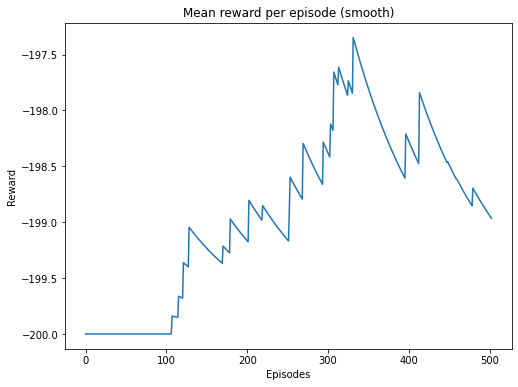

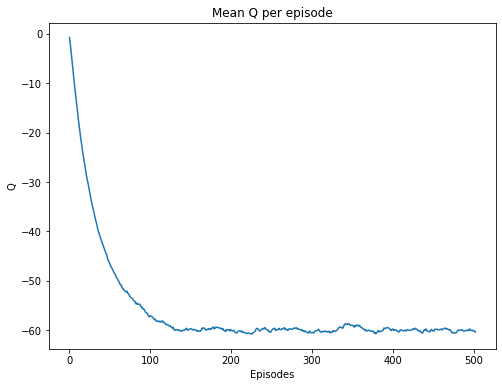

In [33]:
plot_results('EpsGreedy eps=0.1, sigma=1e-1')

#### All Results

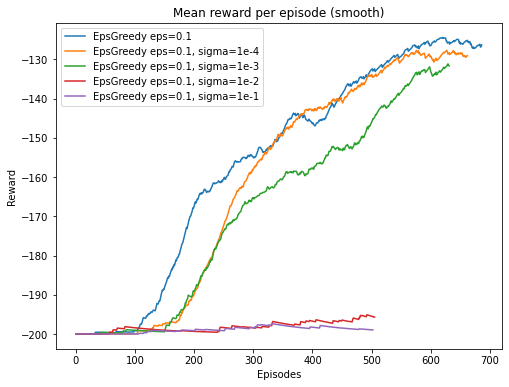

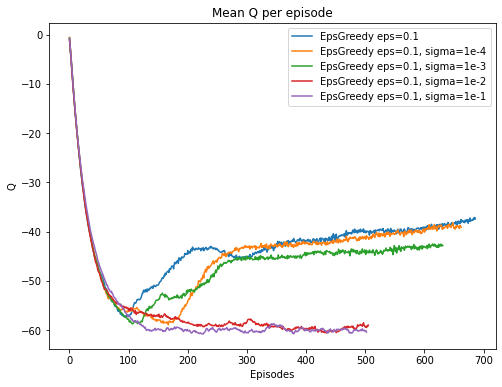

In [35]:
experiments = [
               'EpsGreedy eps=0.1',
               'EpsGreedy eps=0.1, sigma=1e-4',
               'EpsGreedy eps=0.1, sigma=1e-3',
               'EpsGreedy eps=0.1, sigma=1e-2',
               'EpsGreedy eps=0.1, sigma=1e-1',
               ]
plot_results(experiments)